In [1]:
# ==============================================
# PREPROCESSING DATA ULASAN
# ==============================================

import os
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from typing import List

# ----------------------------------------------
# Persiapan resource
# ----------------------------------------------
nltk.download('punkt')
nltk.download('stopwords')

# Path input dan output
INPUT_CSV = "scrapped_data_honkai_star_rail.csv"
OUTPUT_FINAL = "hasil_preprocessing.csv"

# Deteksi kolom teks utama
df = pd.read_csv(INPUT_CSV)
possible_text_cols = ['review', 'content', 'comment', 'text', 'body', 'reviewBody']
TEXT_COL = next((c for c in possible_text_cols if c in df.columns), None)

if TEXT_COL is None:
    raise ValueError("❌ Tidak ditemukan kolom teks utama, sesuaikan nama kolomnya.")

df = df[[TEXT_COL]].rename(columns={TEXT_COL: 'content'}).dropna().reset_index(drop=True)
print(f"✅ Data dimuat: {len(df)} baris. Kolom teks: '{TEXT_COL}'")

# ----------------------------------------------
# Normalisasi kata tidak baku (versi final)
# ----------------------------------------------
normalization_dict = {
    "ga": "tidak", "gak": "tidak", "gaada": "tidak ada", "gacha": "gacha", "pity": "pity", "banner": "banner",
    "bgt": "banget", "aja": "saja", "jd": "jadi", 'yg': 'yang', 'tpi': 'tapi', 'bg': 'bang', 'sy': 'saya',
    'gk': 'tidak', 'dpt': 'dapat', 'bngt': 'banget', 'lg': 'lagi',
    'gw': 'saya', 'gue': 'saya', 'lu': 'kamu', 'udh': 'sudah', 'udah': 'sudah', 'kalo': 'kalau', 
    'kyk': 'seperti', 'jg': 'juga', 'blm': 'belum', 'gmn': 'bagaimana', 'knp': 'kenapa', 'trs': 'terus',
    'sm': 'sama', 'cmn': 'cuma','blum': 'belum', 'nyah': 'nya', 'lagih': 'lagi', 'dapet': 'dapat',
    'gem': 'game', 'relic': 'relic', 'bnyk': 'banyak', 'bgtt': 'banget', 'baiq': 'baik','geme': 'game',
    'gim': 'game', 'heba': 'hebat', 'mantep': 'mantap', 'muas': 'puas', 'pls': 'please', 'ny': 'nya', 
    'pw': 'power'
}

# ----------------------------------------------
# Stopword list gabungan
# ----------------------------------------------
stop_words_id = set(stopwords.words('indonesian'))
stop_words_en = set(stopwords.words('english'))
additional_stopwords = { 
    "game", "nya", "sih", "aja", "yang", "gw", "gua", "gue", "kak", "min", "makasih", 
    "terimakasih", "keren", "ok", "tolong", "mohon", "banget", "si", "bagus", "keren", 
    "mantap", "gamenya", "okelah", "thanks", "good", "nice", "best", "seru", "oke", 
    "terima", "kasih", "semangat", "moga", "thanks", "thank", "you", "please", "main", 
    "baik", "ya", "sehat", "hoyoverse", "coy", "love", "ni", "suck", "like", "make", "play"                  
}
stop_words = stop_words_id.union(stop_words_en).union(additional_stopwords)

# ----------------------------------------------
# Setup stemmer
# ----------------------------------------------
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# ----------------------------------------------
# Fungsi preprocessing per langkah
# ----------------------------------------------
def case_folding(text: str) -> str:
    return str(text).lower()

def clean_text(text: str) -> str:
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def normalize_text(text: str) -> str:
    words = text.split()
    words = [normalization_dict.get(w, w) for w in words]
    return " ".join(words)

def tokenize_text(text: str) -> List[str]:
    return re.findall(r'\b[^\d\W_]+\b', text)

def remove_stopwords(tokens: List[str]) -> List[str]:
    return [t for t in tokens if t not in stop_words]

def stem_tokens(tokens: List[str]) -> List[str]:
    return [stemmer.stem(t) for t in tokens]

# ----------------------------------------------
# Jalankan proses bertahap
# ----------------------------------------------
df["case_folding"] = df["content"].apply(case_folding)
df["cleaned"] = df["case_folding"].apply(clean_text)
df["normalized"] = df["cleaned"].apply(normalize_text)
df["token"] = df["normalized"].apply(tokenize_text)
df["no_stopword"] = df["token"].apply(remove_stopwords)
df["stemmed"] = df["no_stopword"].apply(stem_tokens)
df["clean_final"] = df["stemmed"].apply(lambda x: " ".join(x))
# ----------------------------------------------
# Hapus dokumen kosong saja
# ----------------------------------------------
df["clean_final_length"] = df["clean_final"].str.split().apply(len)
df = df[(df["clean_final"].str.strip() != "")]
df = df.drop(columns=["clean_final_length"])
print(f"✅ Setelah filtering, tersisa {len(df)} ulasan yang tidak kosong.")
# ---------------------------------------------------------
# Hapus dokumen kosong atau terlalu pendek dengan > 3 kata
# ---------------------------------------------------------
# df["clean_final_length"] = df["clean_final"].str.split().apply(len)
# df = df[(df["clean_final"].str.strip() != "") & (df["clean_final_length"] > 3)]
# df = df.drop(columns=["clean_final_length"])
# print(f"✅ Setelah filtering, tersisa {len(df)} ulasan dengan panjang > 3 kata dan tidak kosong.")

# ----------------------------------------------
# Simpan hasil akhir
# ----------------------------------------------
df.to_csv(OUTPUT_FINAL, index=False, encoding="utf-8-sig")
print(f"✅ Hasil preprocessing lengkap disimpan ke '{OUTPUT_FINAL}'")

# ----------------------------------------------
# Tampilkan contoh hasil 10 teratas tiap tahap
# ----------------------------------------------
TOP_N = 10
display_cols = [
    "content", "case_folding", "cleaned", "normalized",
    "token", "no_stopword", "stemmed", "clean_final"
]

print("\n=== Contoh hasil (Top 10) dari setiap tahap preprocessing ===")
display(df[display_cols].head(TOP_N))

# ----------------------------------------------
# Simpan hasil tiap tahap
# ----------------------------------------------

# Buat folder 'samples' jika belum ada
os.makedirs("samples", exist_ok=True)

# Simpan seluruh hasil tiap tahap ke folder 'samples/'
for col in display_cols:
    output_path = os.path.join("samples", f"sample_{col}.csv")
    df[[col]].to_csv(output_path, index=False, encoding="utf-8-sig")

print("\n📁 Semua hasil tiap tahap disimpan di folder './samples/' dengan format 'sample_<tahap>.csv'")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Data dimuat: 25413 baris. Kolom teks: 'content'
✅ Setelah filtering, tersisa 21464 ulasan yang tidak kosong.
✅ Hasil preprocessing lengkap disimpan ke 'hasil_preprocessing.csv'

=== Contoh hasil (Top 10) dari setiap tahap preprocessing ===


content  \
0  udah warp 140 kali masih blum dapat B5 yg ada ...   
1  Bagus game hoyo versi turn base, banyak bansos...   
2      bagus, tapi semenjak update besar bngt GB nya   
3        global passive? HP inflation? pfft* hell no   
4  game nyah sudah saya hapus susah gacha nyah ap...   
5  ga jelas bgt siii, masa pas story di tempat be...   
6  Buat game ini jadi seimbang, jangan buat chara...   
7  walaupun hampir smua nya chara b5 tapi hsr mas...   
8  tlonk adain karakter pacarku, dia mw jadi anak...   
9  GAME JAHAT, STELLAR 8K KU HILANG DI MAKAN BAIL...   

                                        case_folding  \
0  udah warp 140 kali masih blum dapat b5 yg ada ...   
1  bagus game hoyo versi turn base, banyak bansos...   
2      bagus, tapi semenjak update besar bngt gb nya   
3        global passive? hp inflation? pfft* hell no   
4  game nyah sudah saya hapus susah gacha nyah ap...   
5  ga jelas bgt siii, masa pas story di tempat be...   
6  buat game ini jadi seimbang, jangan buat chara...   
7  walaupun hampir smua nya chara b5 tapi hsr mas...   
8  tlonk adain karakter pacarku, dia mw jadi anak...   
9  game jahat, stellar 8k ku hilang di makan bail...   

                                             cleaned  \
0  udah warp kali masih blum dapat b yg ada di ba...   
1  bagus game hoyo versi turn base banyak bansos ...   
2       bagus tapi semenjak update besar bngt gb nya   
3           global passive hp inflation pfft hell no   
4  game nyah sudah saya hapus susah gacha nyah ap...   
5  ga jelas bgt siii masa pas story di tempat ber...   
6  buat game ini jadi seimbang jangan buat charac...   
7  walaupun hampir smua nya chara b tapi hsr masi...   
8  tlonk adain karakter pacarku dia mw jadi anak ...   
9  game jahat stellar k ku hilang di makan bailu ...   

                                          normalized  \
0  sudah warp kali masih belum dapat b yang ada d...   
1  bagus game hoyo versi turn base banyak bansos ...   
2     bagus tapi semenjak update besar banget gb nya   
3           global passive hp inflation pfft hell no   
4  game nya sudah saya hapus susah gacha nya apa ...   
5  tidak jelas banget siii masa pas story di temp...   
6  buat game ini jadi seimbang jangan buat charac...   
7  walaupun hampir smua nya chara b tapi hsr masi...   
8  tlonk adain karakter pacarku dia mw jadi anak ...   
9  game jahat stellar k ku hilang di makan bailu ...   

                                               token  \
0  [sudah, warp, kali, masih, belum, dapat, b, ya...   
1  [bagus, game, hoyo, versi, turn, base, banyak,...   
2  [bagus, tapi, semenjak, update, besar, banget,...   
3   [global, passive, hp, inflation, pfft, hell, no]   
4  [game, nya, sudah, saya, hapus, susah, gacha, ...   
5  [tidak, jelas, banget, siii, masa, pas, story,...   
6  [buat, game, ini, jadi, seimbang, jangan, buat...   
7  [walaupun, hampir, smua, nya, chara, b, tapi, ...   
8  [tlonk, adain, karakter, pacarku, dia, mw, jad...   
9  [game, jahat, stellar, k, ku, hilang, di, maka...   

                                         no_stopword  \
0  [warp, kali, b, banernya, clara, warp, sisa, b...   
1  [hoyo, versi, turn, base, bansos, kekurangan, ...   
2                             [semenjak, update, gb]   
3       [global, passive, hp, inflation, pfft, hell]   
4  [hapus, susah, gacha, free, nyari, ngumpulin, ...   
5  [siii, pas, story, bersalju, nolongin, orang, ...   
6                    [seimbang, character, terpakai]   
7  [smua, chara, b, hsr, rajin, ngasih, bansos, t...   
8  [tlonk, adain, karakter, pacarku, mw, anak, ke...   
9  [jahat, stellar, k, ku, hilang, makan, bailu, ...   

                                             stemmed  \
0  [warp, kali, b, banernya, clara, warp, sisa, b...   
1  [hoyo, versi, turn, base, bansos, kurang, gach...   
2                             [semenjak, update, gb]   
3       [global, passive, hp, inflation, pfft, hell]   
4  [hapus, susah, gacha, free, nyari, ngumpulin, ...   
5  [sii


📁 Semua hasil tiap tahap disimpan di folder './samples/' dengan format 'sample_<tahap>.csv'


Data hasil preprocessing berhasil dimuat. Jumlah dokumen: 21464
Memuat model dari path lokal: './model/indobert-base-p1'...


2025-10-31 18:54:25,771 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Memuat embeddings dari cache...
Shape embeddings: (21464, 768)


2025-10-31 18:55:10,691 - BERTopic - Dimensionality - Completed ✓
2025-10-31 18:55:10,691 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-31 18:55:37,843 - BERTopic - Cluster - Completed ✓
2025-10-31 18:55:37,879 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-31 18:55:41,146 - BERTopic - Representation - Completed ✓
2025-10-31 18:55:41,859 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Memulai pelatihan model BERTopic...


2025-10-31 18:56:40,662 - BERTopic - Dimensionality - Completed ✓
2025-10-31 18:56:40,679 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-31 18:56:52,278 - BERTopic - Cluster - Completed ✓
2025-10-31 18:56:52,294 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-31 18:56:55,180 - BERTopic - Representation - Completed ✓


Pelatihan selesai dalam 1.23 menit.
Jumlah topik efektif: 55
Proporsi outlier: 51.06%
Informasi Topik Utama:
   Topic  Count                              Name  \
0     -1  10959      -1_gacha_karakter_suka_story   
1      0   1782         0_login_data_download_pas   
2      1    838      1_karakter_story_player_char   
3      2    680       2_really_even_get_character   
4      3    455  3_gameplay_cerita_tarik_karakter   

                                      Representation  \
0  [gacha, karakter, suka, story, genshin, grafik...   
1  [login, data, download, pas, masuk, error, upd...   
2  [karakter, story, player, char, gacha, konten,...   
3  [really, even, get, character, characters, new...   
4  [gameplay, cerita, tarik, karakter, grafik, st...   

                                 Representative_Docs  
0                          [grafik, grafik, genshin]  
1  [login error mulu, login error mulu, login err...  
2  [stop inflasi hp konten end pikir tebal darah ...  
3  [inflation h

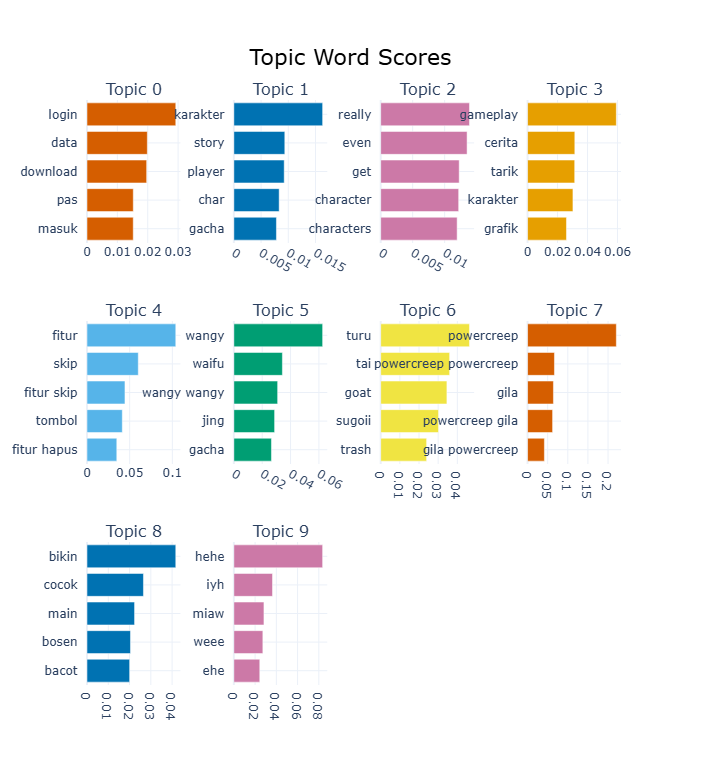

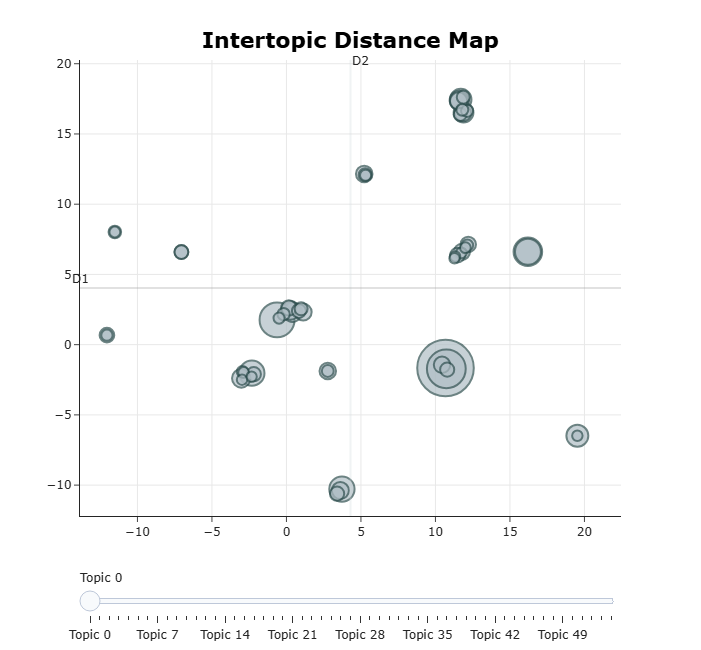

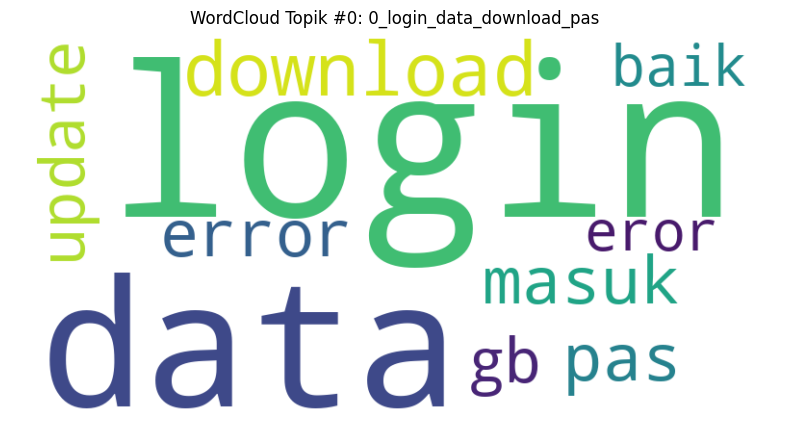

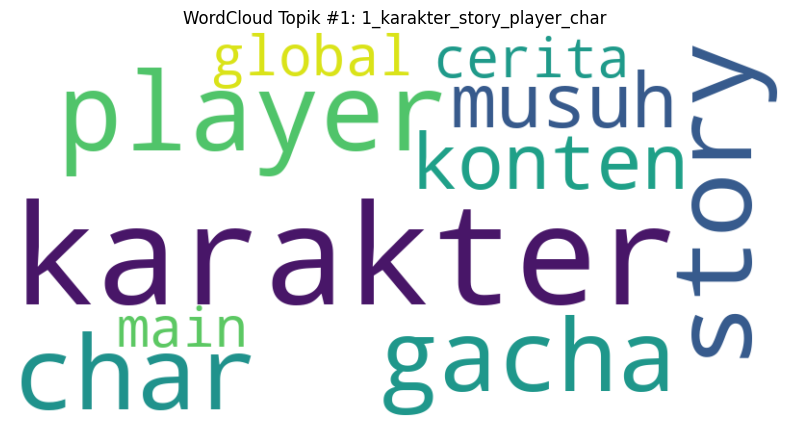

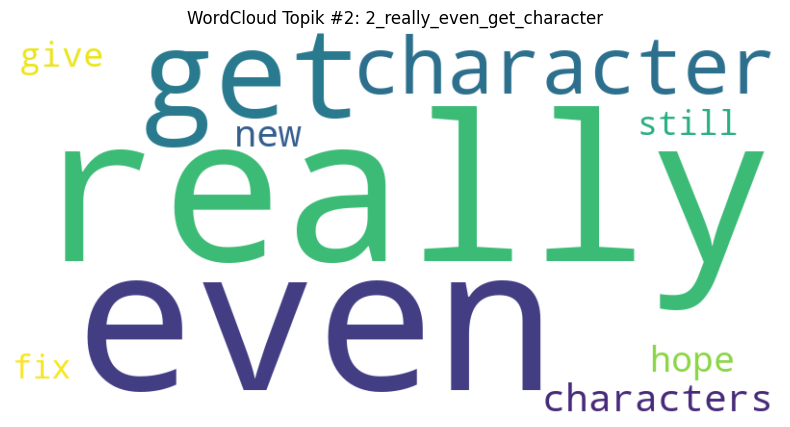

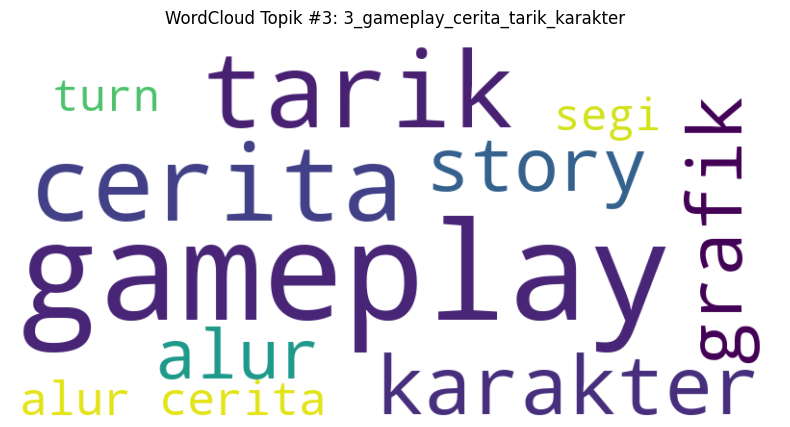

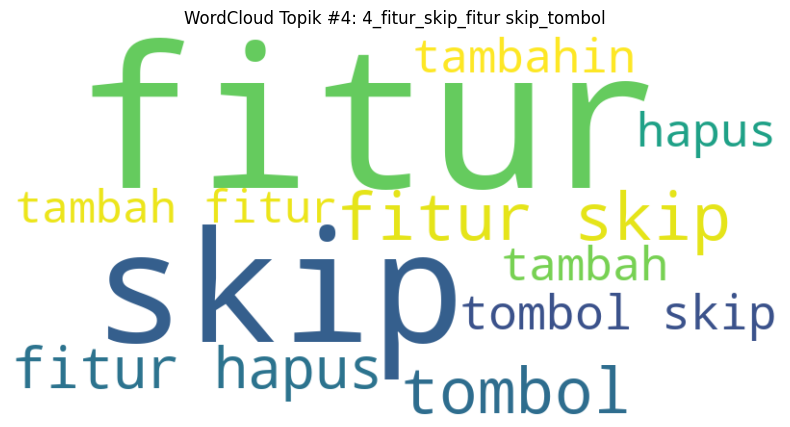

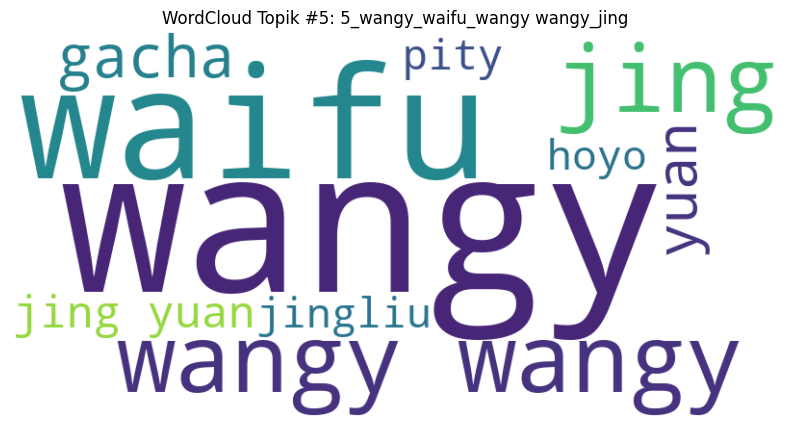

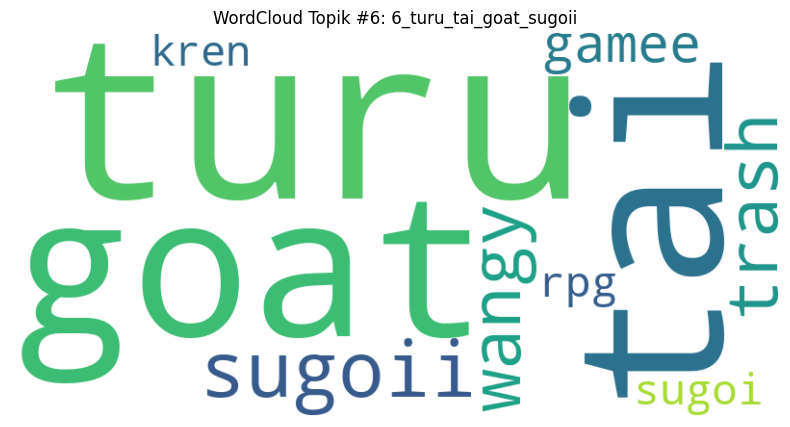

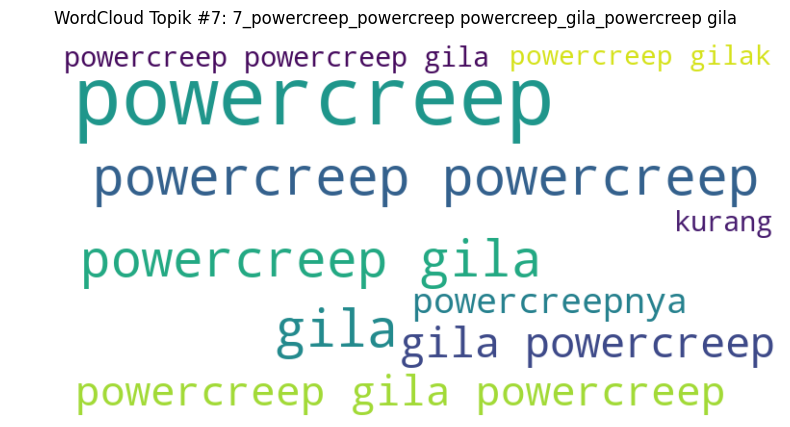

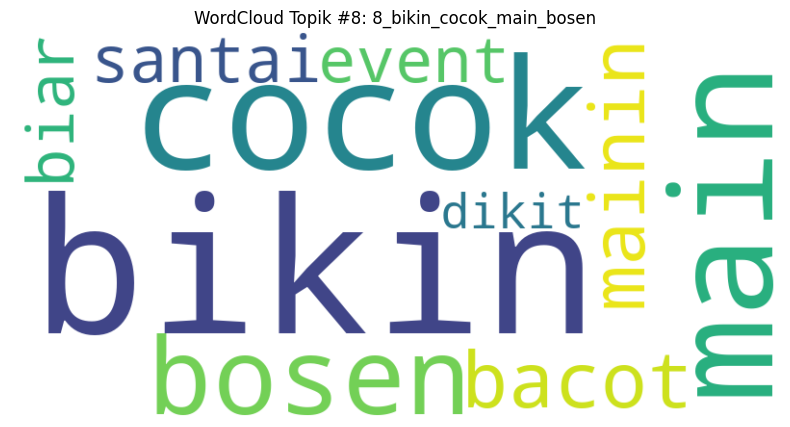

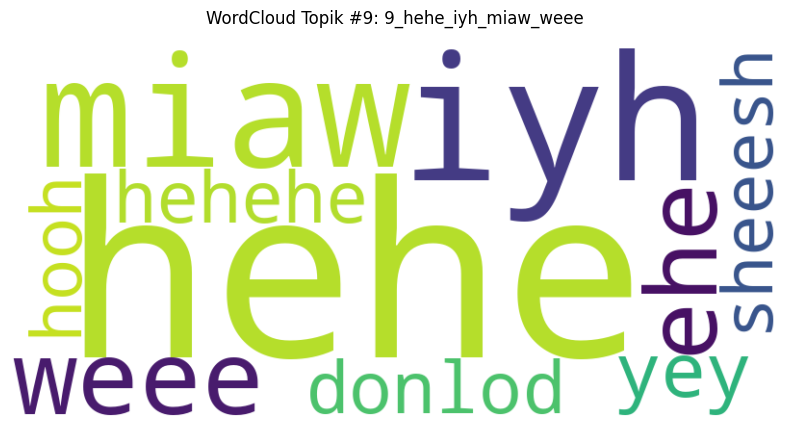

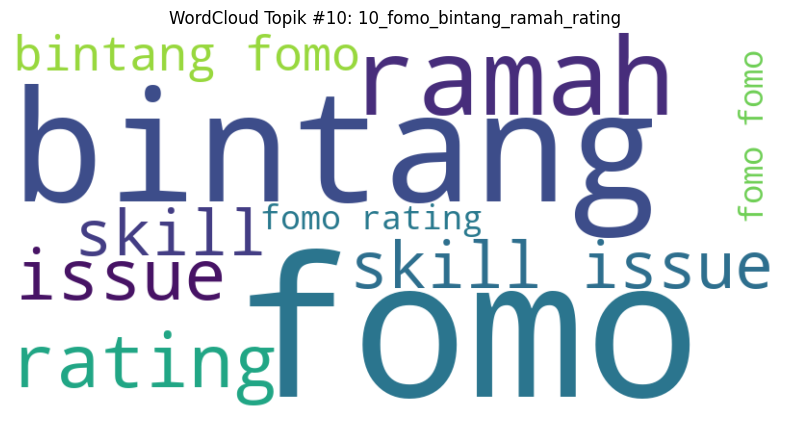

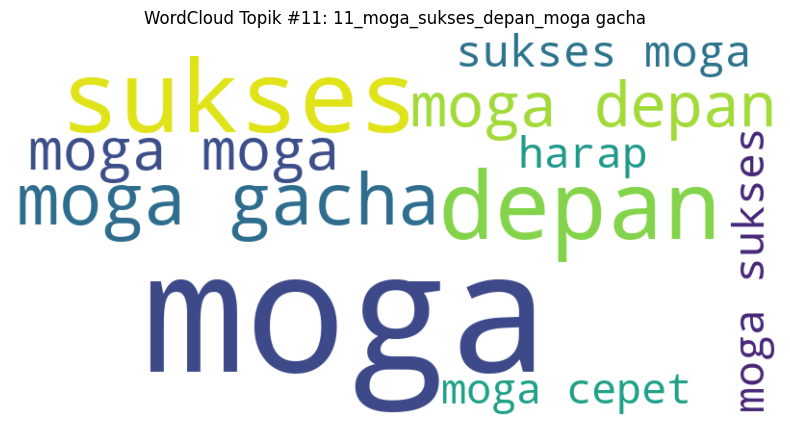

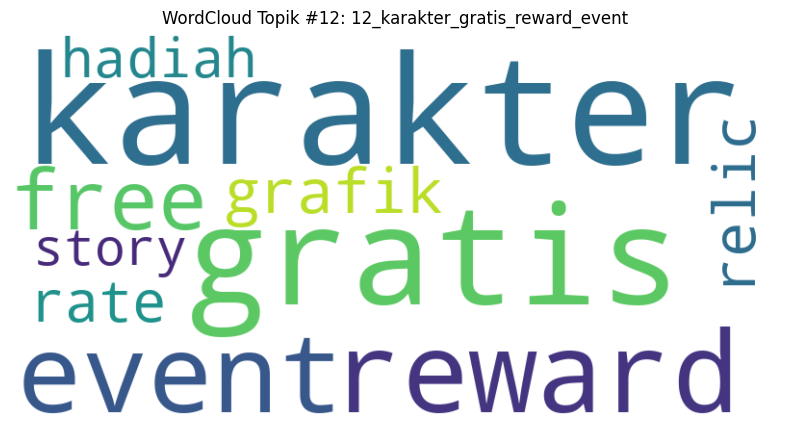

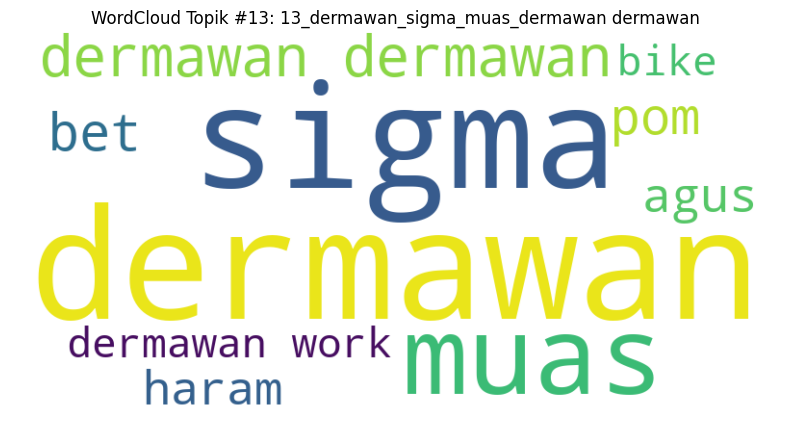

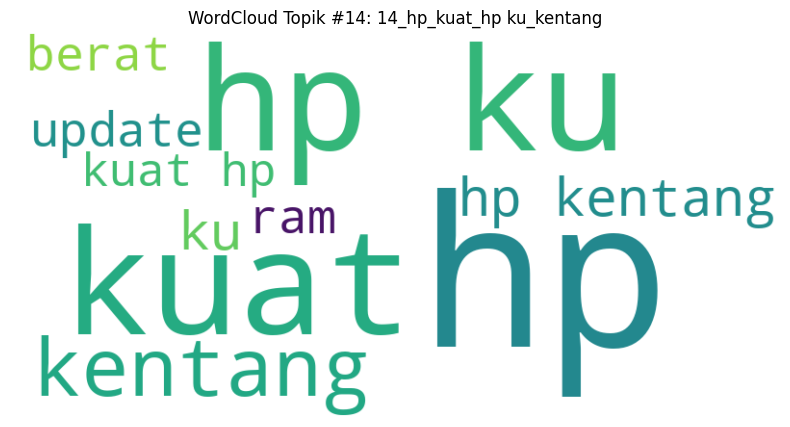

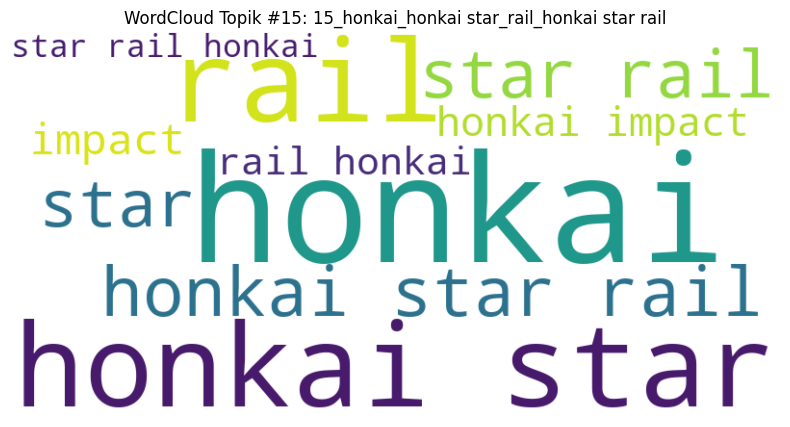

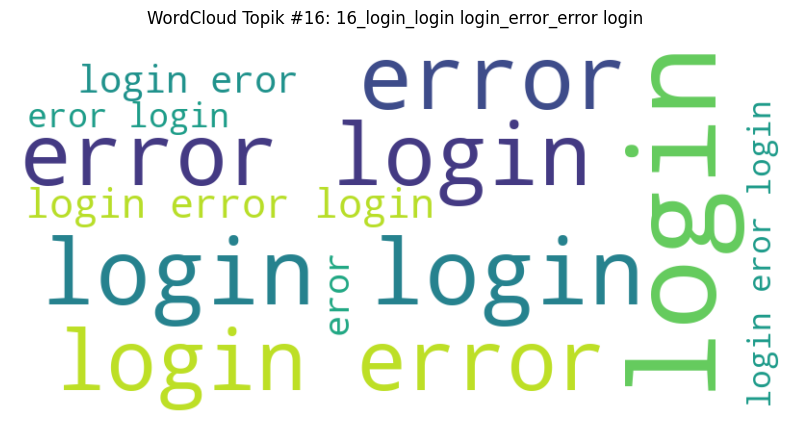

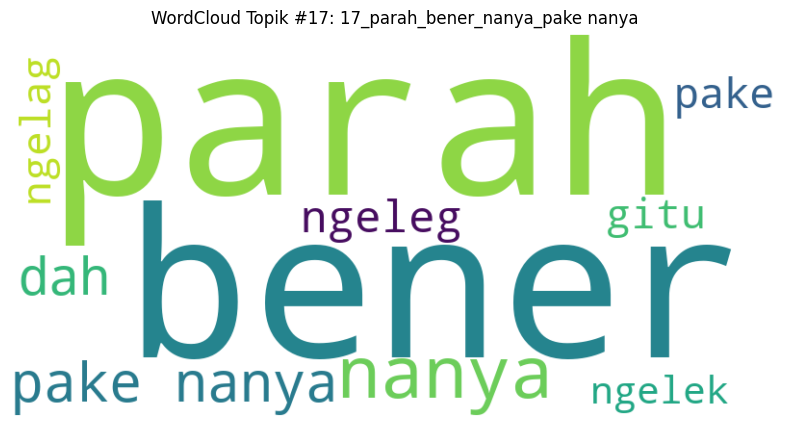

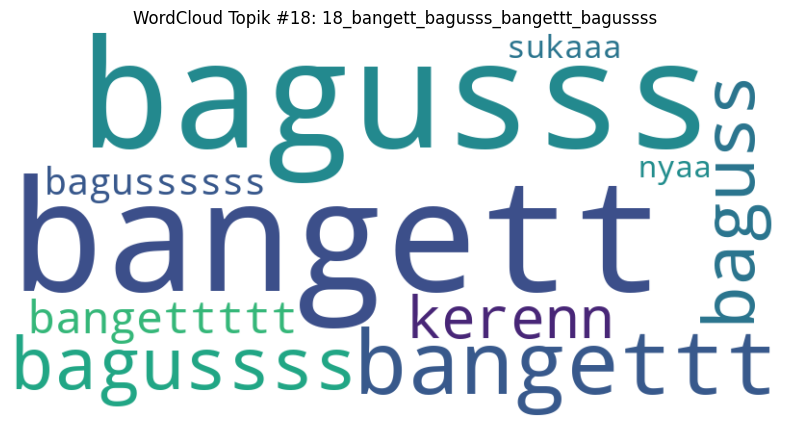

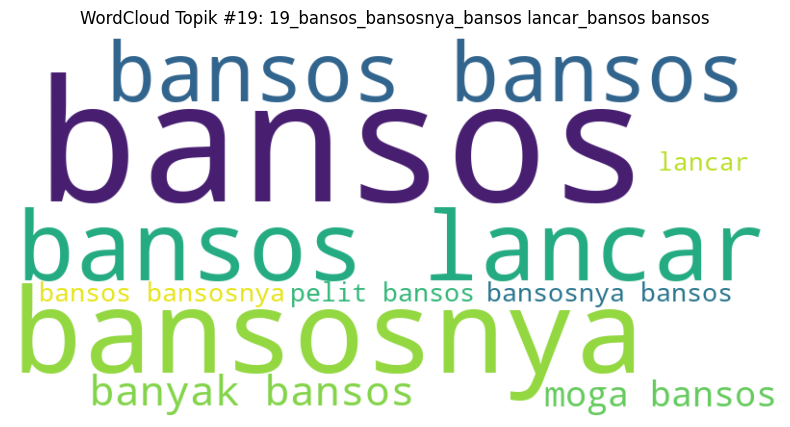

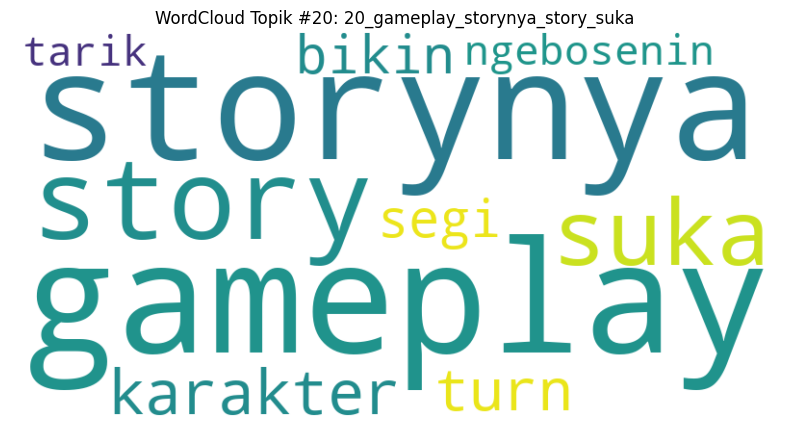

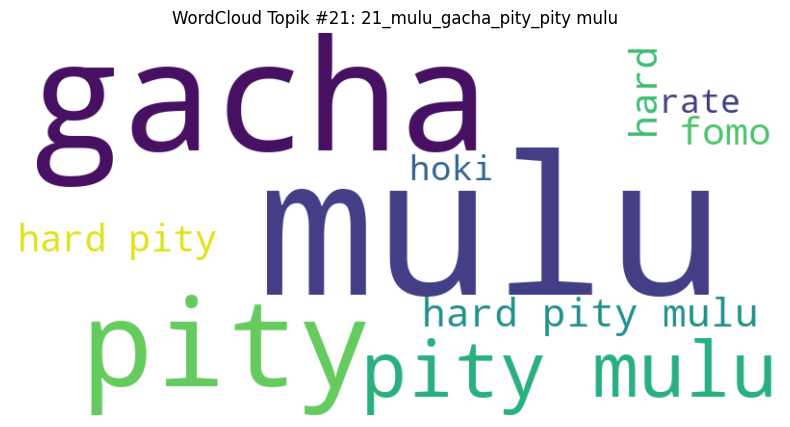

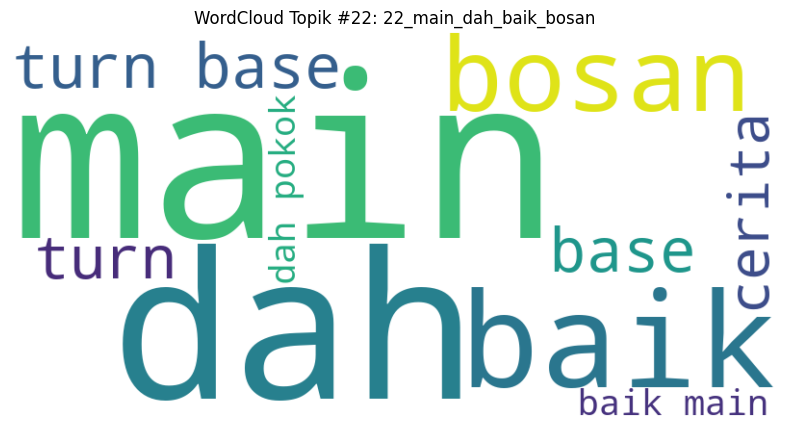

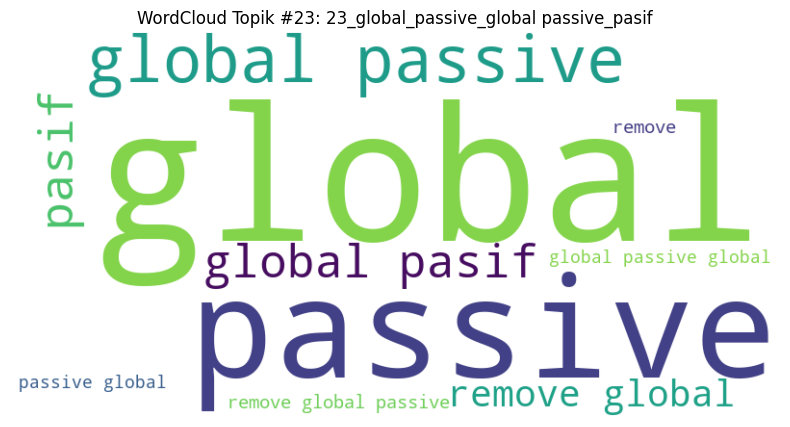

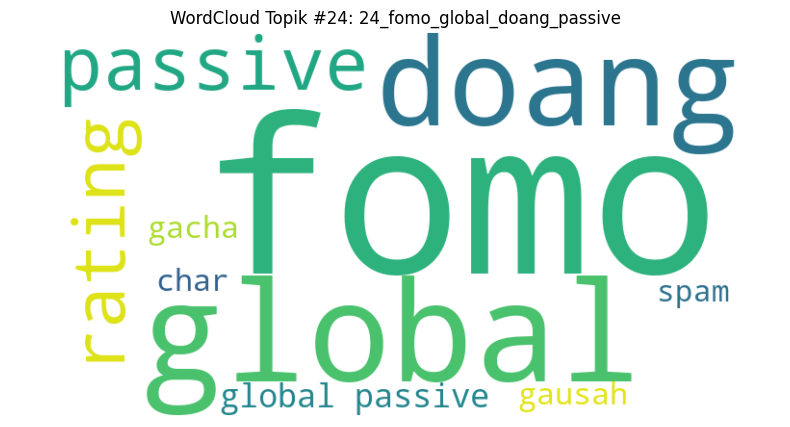

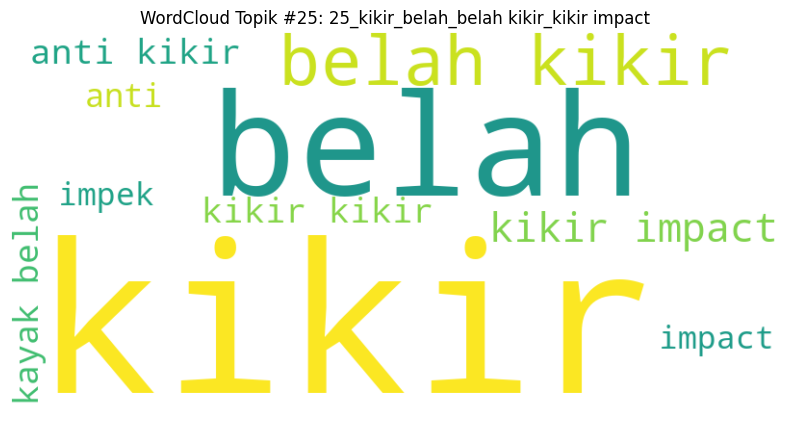

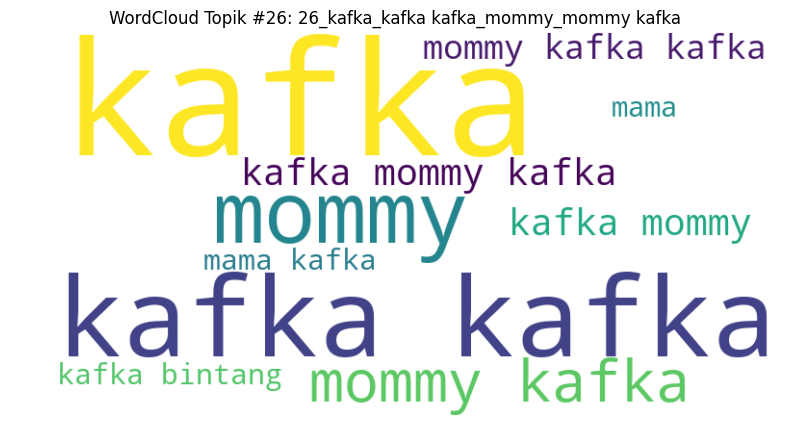

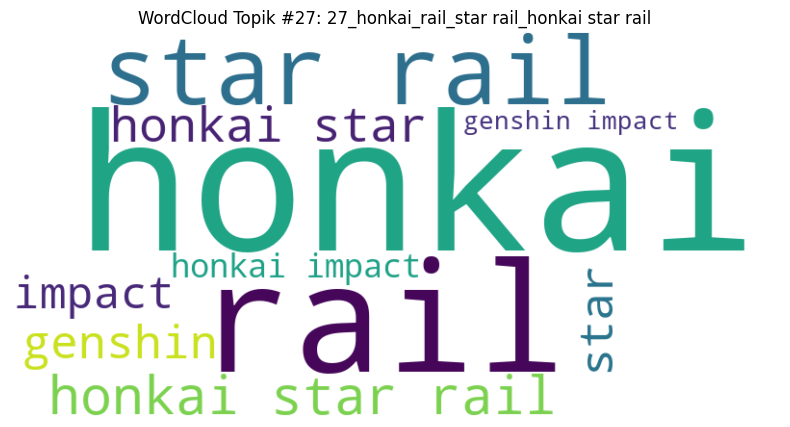

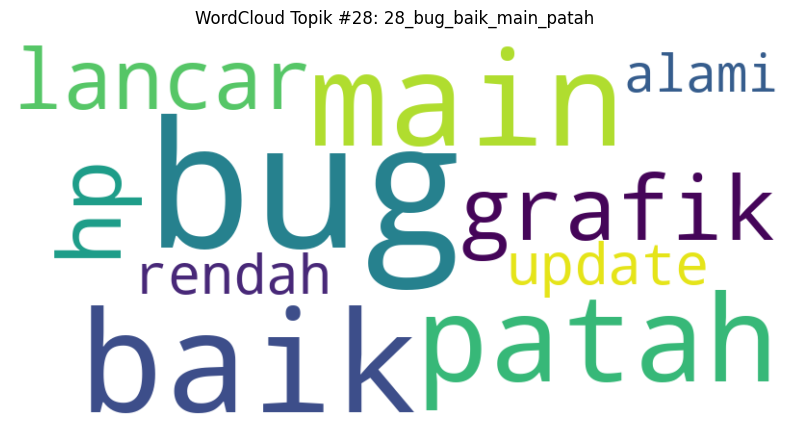

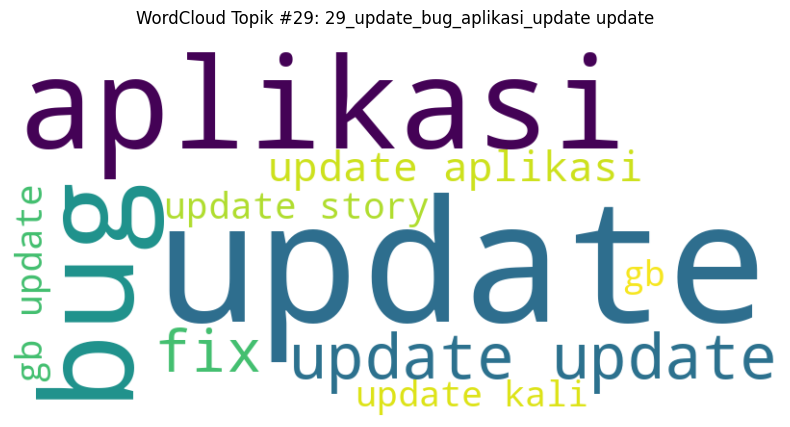

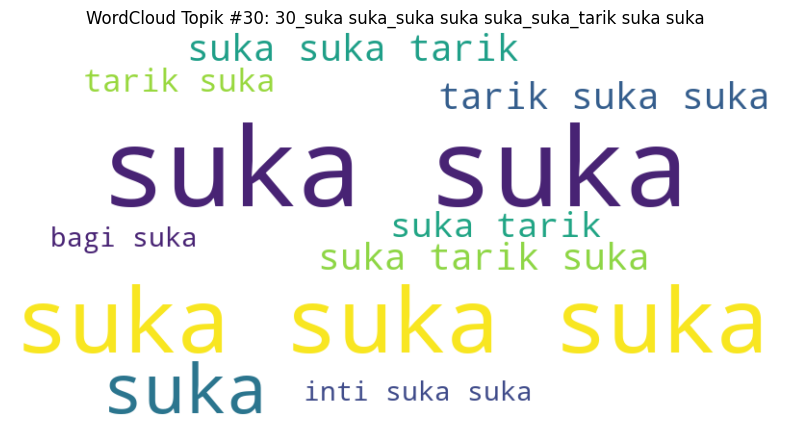

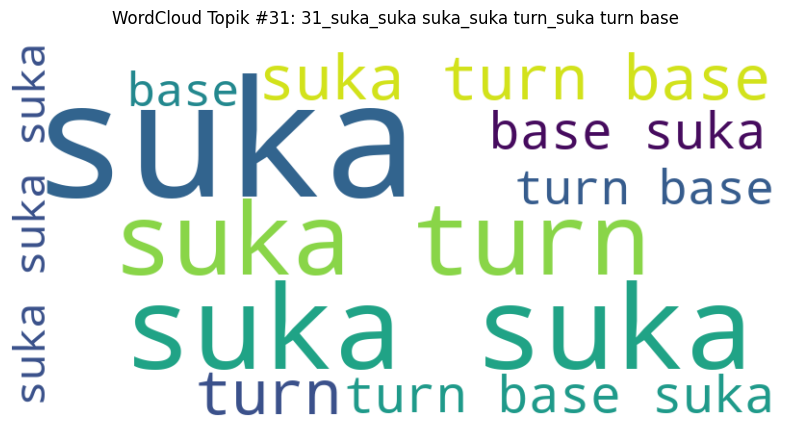

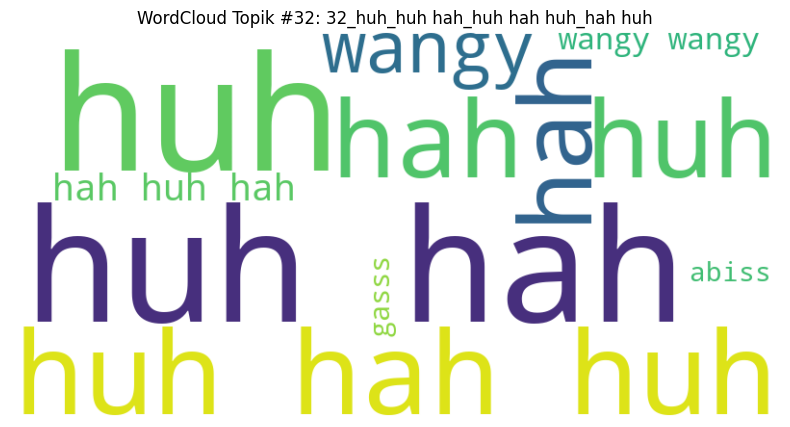

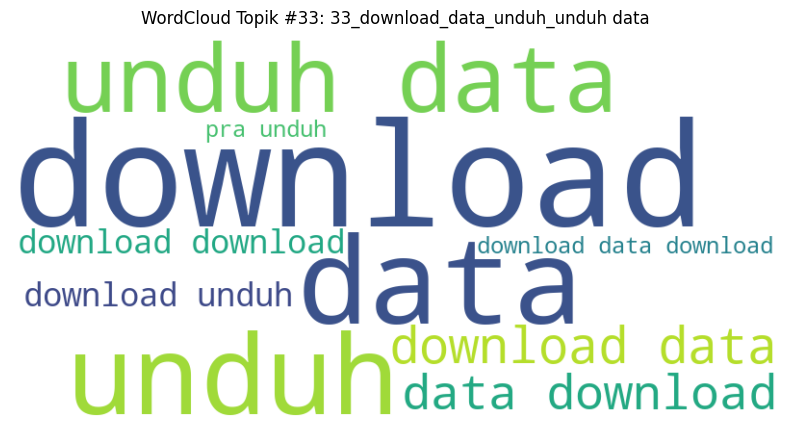

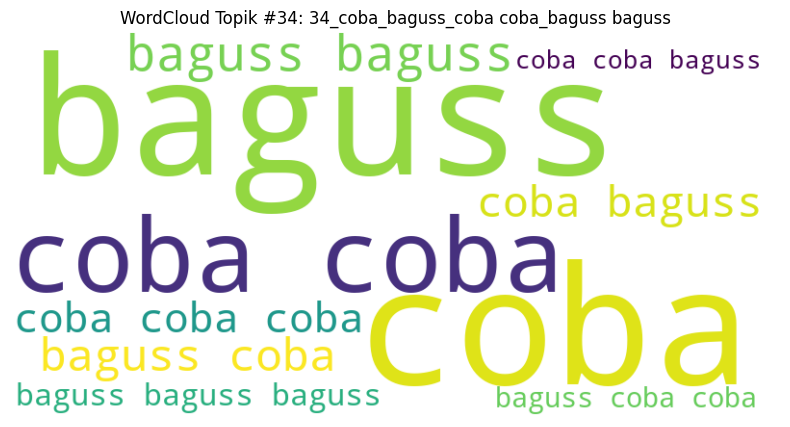

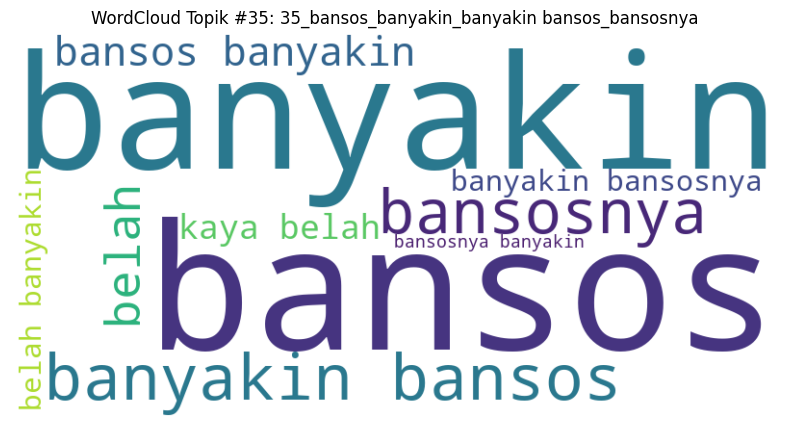

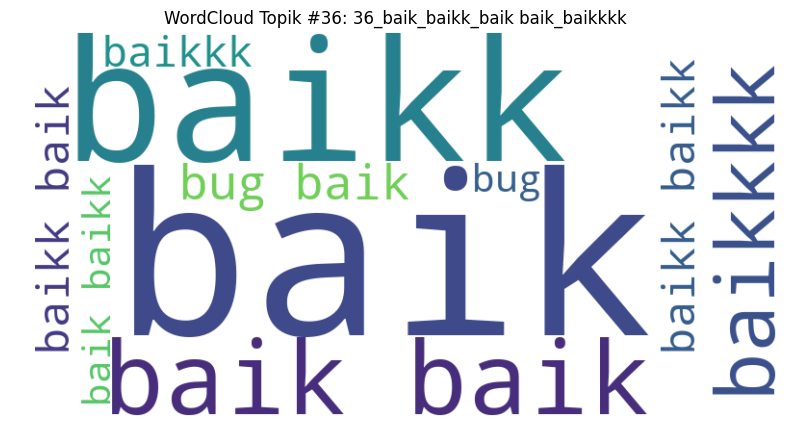

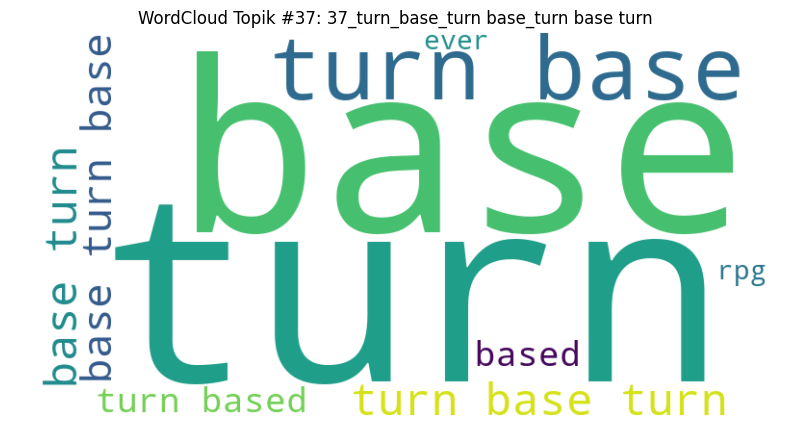

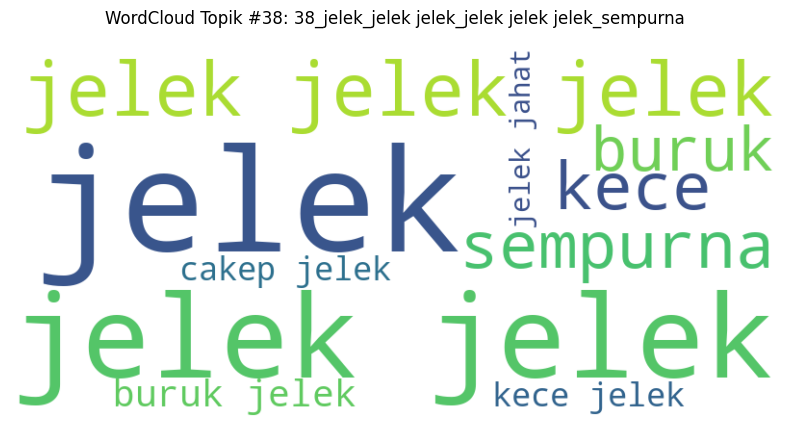

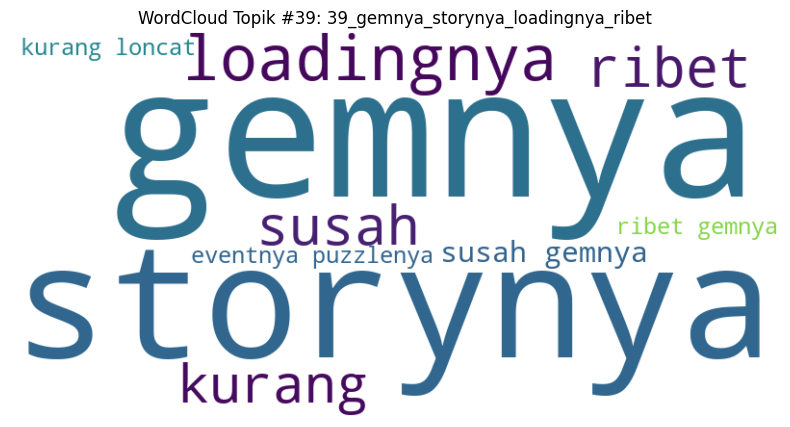

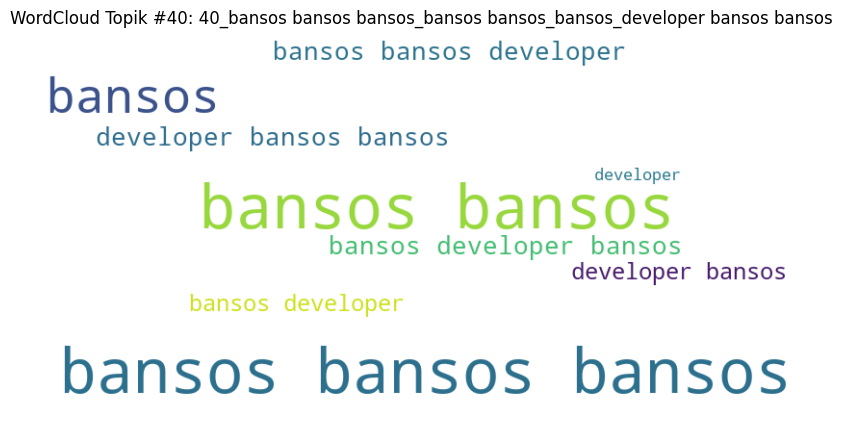

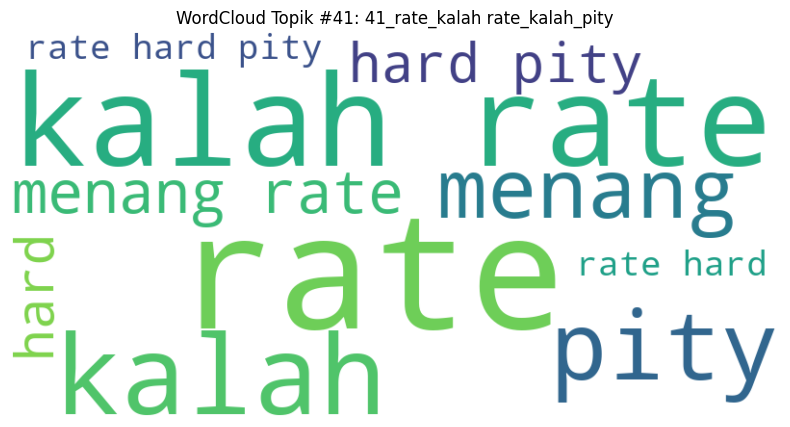

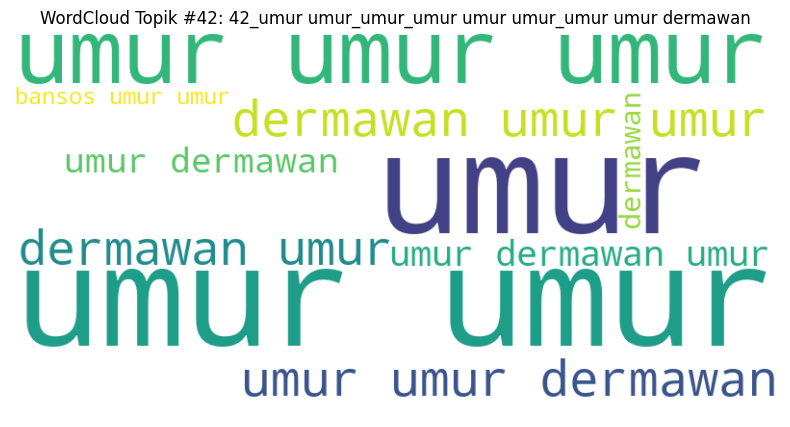

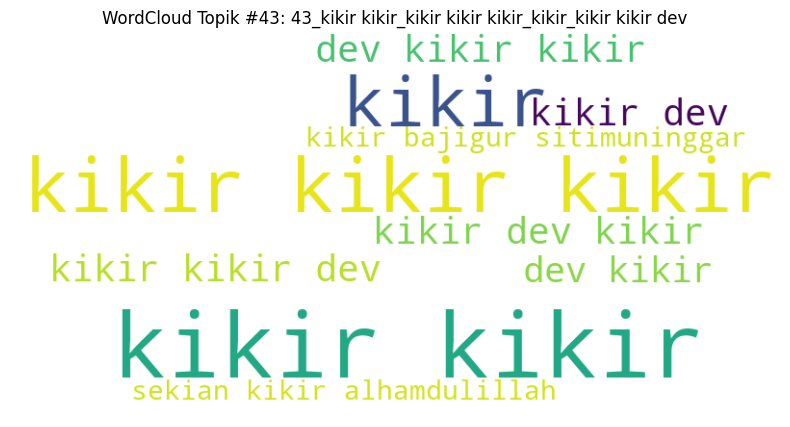

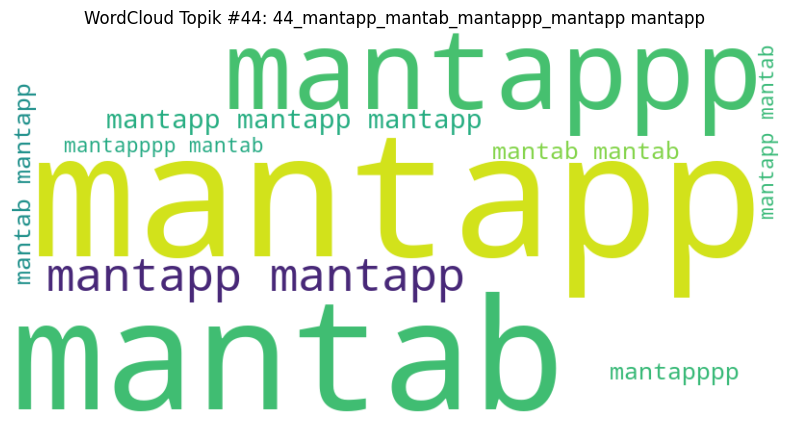

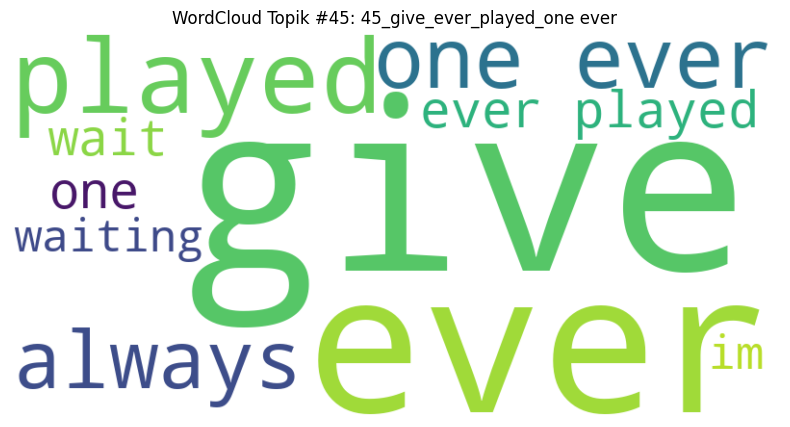

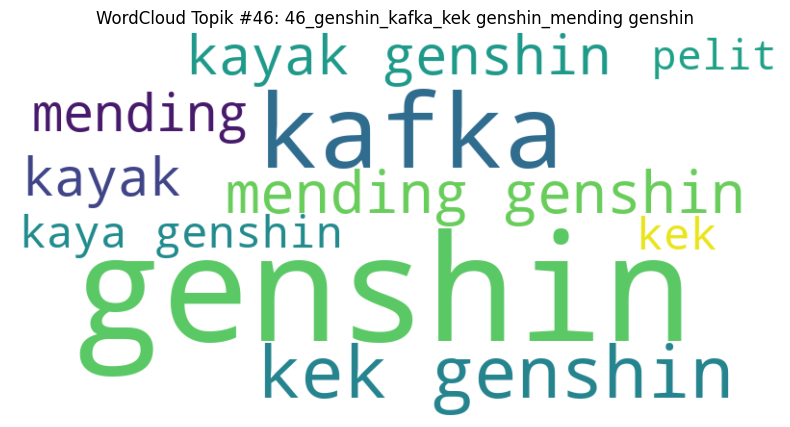

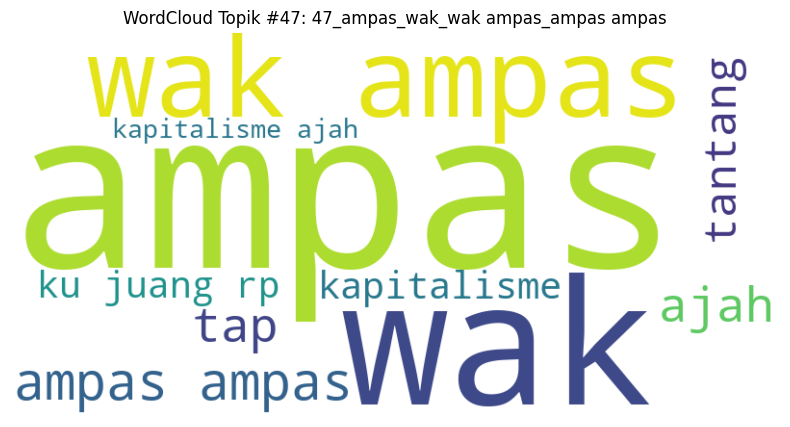

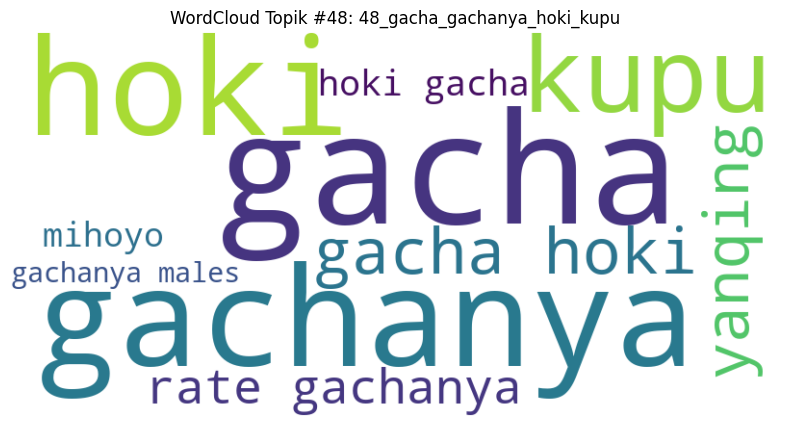

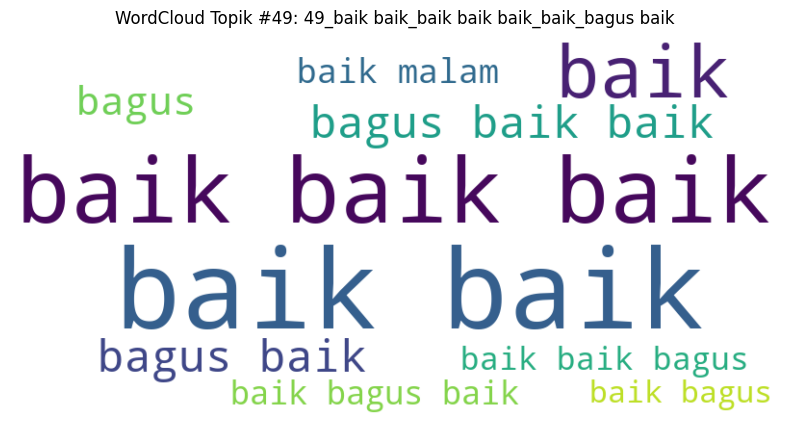

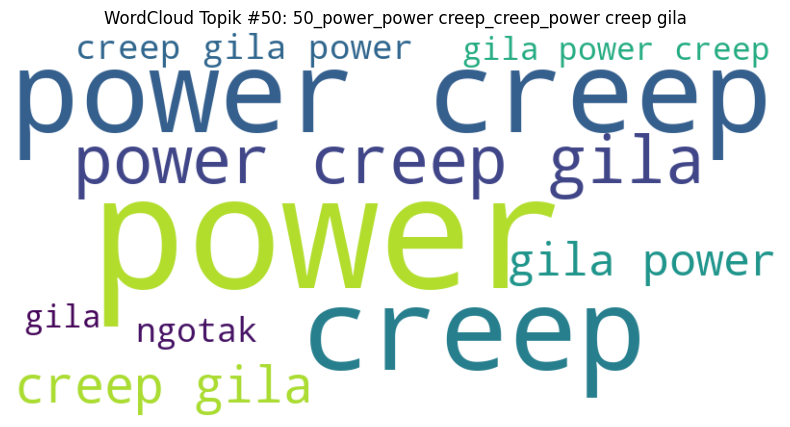

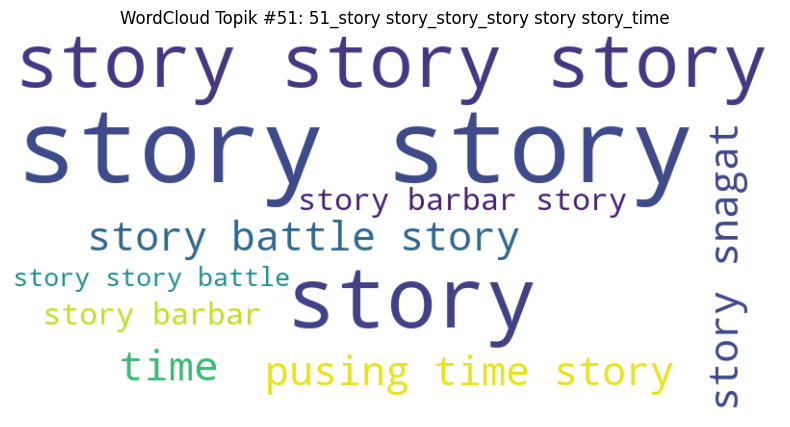

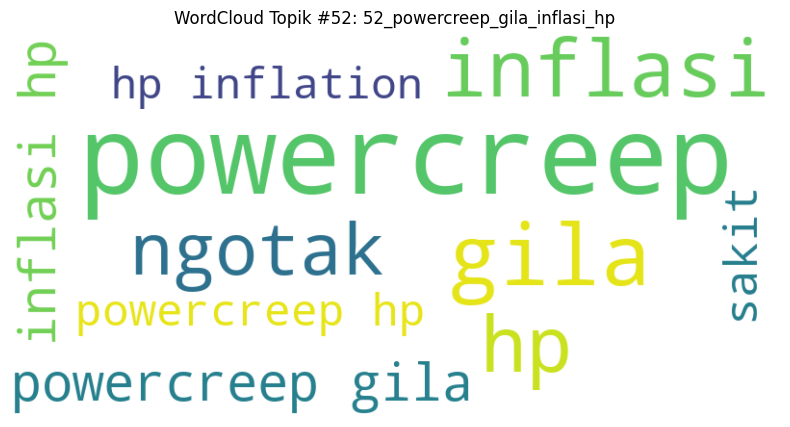

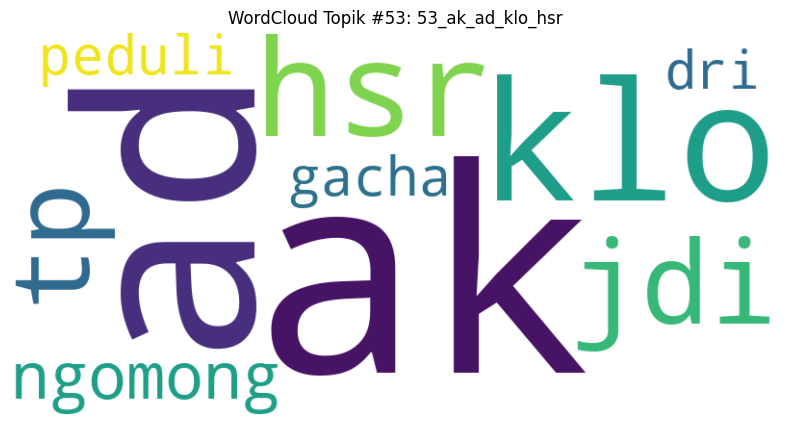

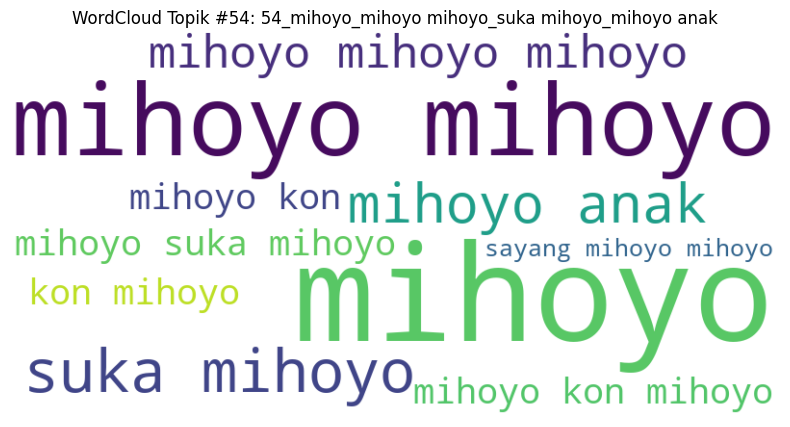


 Semua hasil telah disimpan di folder 'Hasil'.


In [9]:
# ==============================================================
# TAHAP 2 & 3: TRANSFORMASI & PEMODELAN TOPIK
# ==============================================================
# Tahap ini mencakup pembangkitan embeddings menggunakan IndoBERT
# dan pembentukan topik dengan algoritma BERTopic berbasis HDBSCAN dan UMAP.
# ==============================================================
import pandas as pd
import numpy as np
import os
import time
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1️ LOAD DATA HASIL PREPROCESSING
# --------------------------------------------------------------
preprocessed_path = "hasil_preprocessing.csv"

if not os.path.exists(preprocessed_path):
    raise FileNotFoundError(f"File {preprocessed_path} tidak ditemukan. Jalankan tahap preprocessing terlebih dahulu.")

df = pd.read_csv(preprocessed_path)
docs = df["clean_final"].astype(str).tolist()

print(f"Data hasil preprocessing berhasil dimuat. Jumlah dokumen: {len(docs)}")

# --------------------------------------------------------------
# 2️ MEMUAT MODEL EMBEDDING (INDOBERT)
# --------------------------------------------------------------
local_model_path = "./model/indobert-base-p1"
if os.path.exists(local_model_path):
    print(f"Memuat model dari path lokal: '{local_model_path}'...")
    embedding_model = SentenceTransformer(local_model_path)
else:
    print("Model lokal tidak ditemukan. Mengunduh dari Hugging Face...")
    embedding_model = SentenceTransformer("indobenchmark/indobert-base-p1")

# --------------------------------------------------------------
# 3️ MENGHITUNG ATAU MEMUAT EMBEDDINGS
# --------------------------------------------------------------
embedding_path = f"embeddings_{len(docs)}.npy"

if os.path.exists(embedding_path):
    print("Memuat embeddings dari cache...")
    embeddings = np.load(embedding_path)
else:
    print("Menghitung embeddings baru...")
    start = time.time()
    embeddings = embedding_model.encode(docs, batch_size=32, show_progress_bar=True)
    np.save(embedding_path, embeddings)
    print(f"Embeddings disimpan ke: {embedding_path}")
    print(f"Waktu komputasi embeddings: {(time.time()-start)/60:.2f} menit")

print(f"Shape embeddings: {embeddings.shape}")

# --------------------------------------------------------------
# 4️ PENENTUAN PARAMETER OTOMATIS (BERDASARKAN UKURAN DATA)
# --------------------------------------------------------------
def auto_params(num_docs: int):
    """
    Menentukan parameter otomatis untuk BERTopic berdasarkan jumlah dokumen.
    Semakin besar dataset, semakin besar cluster dan lebih ketat filtering-nya.
    """
    if num_docs < 1000:
        return {"min_df": 1, "n_neighbors": 8, "min_cluster_size": 8, "min_samples": 5}
    elif num_docs < 3000:
        return {"min_df": 2, "n_neighbors": 10, "min_cluster_size": 15, "min_samples": 7}
    elif num_docs < 7000:
        return {"min_df": 3, "n_neighbors": 15, "min_cluster_size": 30, "min_samples": 10}
    elif num_docs < 15000:
        return {"min_df": 5, "n_neighbors": 20, "min_cluster_size": 50, "min_samples": 12}
    else:
        return {"min_df": 0.002, "n_neighbors": 20, "min_cluster_size": 60, "min_samples": 12}
   

# --------------------------------------------------------------
# 5️ KONFIGURASI MODEL UMAP, HDBSCAN, DAN BERTOPIC
# --------------------------------------------------------------
params = auto_params(len(df))

vectorizer_model = CountVectorizer(max_df=0.8, min_df=params["min_df"], ngram_range=(1,3))
umap_model = UMAP(n_neighbors=params["n_neighbors"], n_components=5, min_dist=0.0, metric="cosine", random_state=42)
hdbscan_model = HDBSCAN(
    min_cluster_size=params["min_cluster_size"],
    min_samples=params["min_samples"],
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)


# --------------------------------------------------------------
# 6️ FIT MODEL & PEMODELAN TOPIK
# --------------------------------------------------------------
print("Memulai pelatihan model BERTopic...")
start_time = time.time()
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
duration = (time.time() - start_time) / 60
print(f"Pelatihan selesai dalam {duration:.2f} menit.")

unique_topics = len(set([t for t in topics if t != -1]))
outlier_ratio = sum([1 for t in topics if t == -1]) / len(topics)
print(f"Jumlah topik efektif: {unique_topics}")
print(f"Proporsi outlier: {outlier_ratio:.2%}")

# --------------------------------------------------------------
# 7️ EVALUASI MODEL (KUALITATIF & KUANTITATIF)
# --------------------------------------------------------------
topic_info = topic_model.get_topic_info()
print("Informasi Topik Utama:")
print(topic_info.head())

# Hitung koherensi topik
topics_for_eval = []
for topic_id in topic_info[topic_info["Topic"] != -1]["Topic"]:
    words = [w for w, _ in topic_model.get_topic(topic_id)]
    topics_for_eval.append(words)

if topics_for_eval:
    tokenized_docs = [doc.split() for doc in docs]
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(toks) for toks in tokenized_docs]
    cm = CoherenceModel(topics=topics_for_eval, texts=tokenized_docs, dictionary=dictionary, coherence="c_v")
    coherence_score = cm.get_coherence()
    print(f"Skor Koherensi Rata-rata (c_v): {coherence_score:.4f}")
else:
    print("Tidak cukup topik untuk menghitung skor koherensi.")

# --------------------------------------------------------------
# 8️ VISUALISASI WORDCLOUD PER TOPIK
# --------------------------------------------------------------
print("\n Membuat visualisasi...")

# --- A. Bar Chart Distribusi Topik ---
fig_bar = topic_model.visualize_barchart(top_n_topics=10)
fig_bar.show()

# --- B. Intertopic Distance Map ---
fig_map = topic_model.visualize_topics()
fig_map.update_layout(
   xaxis={
        "visible": True,        # <-- KUNCI UTAMA: Paksa sumbu X untuk terlihat
        "showticklabels": True, # Tampilkan label angka
        "showgrid": True        # Tampilkan grid
    },
    yaxis={
        "visible": True,        # <-- KUNCI UTAMA: Paksa sumbu Y untuk terlihat
        "showticklabels": True, # Tampilkan label angka
        "showgrid": True        # Tampilkan grid
    }
)
fig_map.show()

# --- C. WordCloud untuk Setiap Topik (Top 10 kata) ---
output_wc_dir = os.path.join(output_dir, "wordclouds")
os.makedirs(output_wc_dir, exist_ok=True)

print("\nMembuat WordCloud untuk setiap topik (10 kata teratas)...")

for topic_id in topic_info[topic_info["Topic"] != -1]["Topic"]:
    # Ambil 10 kata teratas berdasarkan bobot
    top_words = topic_model.get_topic(topic_id)[:10]  # ambil hanya 10 teratas
    freq_dict = dict(top_words)

    # Buat WordCloud
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color="white", 
        colormap="viridis"
    ).generate_from_frequencies(freq_dict)

    # Tampilkan dan simpan
    plt.figure(figsize=(10, 5))
    title = topic_info.loc[topic_info.Topic == topic_id, "Name"].iloc[0]
    plt.title(f"WordCloud Topik #{topic_id}: {title}")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    save_path = os.path.join(output_wc_dir, f"wordcloud_topic_{topic_id}.png")
    plt.savefig(save_path, bbox_inches='tight')

print(f"\nSemua WordCloud berhasil disimpan di folder: {output_wc_dir}")


# --------------------------------------------------------------
# 9️ SIMPAN HASIL AKHIR KE CSV
# --------------------------------------------------------------
output_dir = "Hasil"
os.makedirs(output_dir, exist_ok=True)

topic_info.to_csv(f"{output_dir}/hasil_analisis_topik_{len(docs)}.csv", index=False, encoding="utf-8-sig")

rep_docs = []
for topic_id in topic_info[topic_info["Topic"] != -1]["Topic"]:
    docs_rep = topic_model.get_representative_docs(topic_id)
    for d in docs_rep:
        rep_docs.append({"Topic_ID": topic_id, "Representative_Doc": d})
pd.DataFrame(rep_docs).to_excel(f"{output_dir}/dokumen_representatif_{len(docs)}.xlsx", index=False)

print(f"\n Semua hasil telah disimpan di folder '{output_dir}'.")
